In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold



In [15]:
# Load the dataset
dataset_path = 'bank-additional-full.csv'
data = pd.read_csv(dataset_path, delimiter=';')

print(data.head())

# Convert categorical features to dummy variables
data = pd.get_dummies(data, drop_first=True)

# Target variable is 'y_yes'
X = data.drop(columns=['y_yes'])
y = data['y_yes']



   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

In [16]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale numerical features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)



In [17]:
# Model 1: Random Forest
# Hyperparameter tuning using GridSearchCV
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Best Random Forest Model
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_train_resampled, y_train_resampled)

# Random Forest Predictions and Evaluation
rf_proba = best_rf_model.predict_proba(X_test)[:, 1]
rf_predictions = (rf_proba >= 0.5).astype(int)



In [19]:
# Model 2: Neural Network
# Hyperparameter tuning using GridSearchCV
nn_model = MLPClassifier(max_iter=1000, random_state=42)
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 30)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001]
}
grid_search_nn = GridSearchCV(estimator=nn_model, param_grid=param_grid_nn, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_nn.fit(X_train_resampled, y_train_resampled)

# Best Neural Network Model
best_nn_model = grid_search_nn.best_estimator_
best_nn_model.fit(X_train_resampled, y_train_resampled)

# Neural Network Predictions and Evaluation
nn_proba = best_nn_model.predict_proba(X_test)[:, 1]
nn_predictions = (nn_proba >= 0.5).astype(int)



In [20]:
# Classification Reports
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

print("\nNeural Network Classification Report:")
print(classification_report(y_test, nn_predictions))




Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.95      0.95      7310
        True       0.62      0.63      0.63       928

    accuracy                           0.92      8238
   macro avg       0.79      0.79      0.79      8238
weighted avg       0.92      0.92      0.92      8238


Neural Network Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.95      0.94      7310
        True       0.56      0.49      0.53       928

    accuracy                           0.90      8238
   macro avg       0.75      0.72      0.73      8238
weighted avg       0.89      0.90      0.90      8238



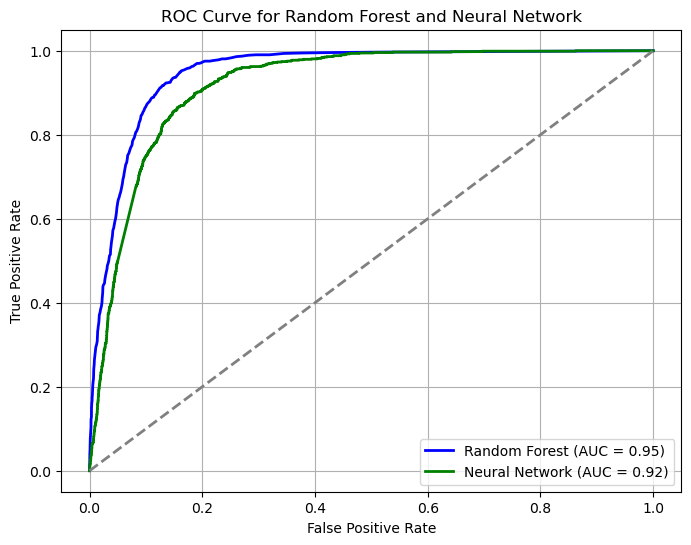

In [21]:
# Compute ROC curve for both models
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_proba)

# Compute AUC for both models
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Plot ROC curve for both models
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_nn, tpr_nn, color='green', lw=2, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line (no discrimination)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest and Neural Network')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [22]:
# Confusion Matrices
rf_cm = confusion_matrix(y_test, rf_predictions)
nn_cm = confusion_matrix(y_test, nn_predictions)

print("\nRandom Forest Confusion Matrix:")
print(rf_cm)

print("\nNeural Network Confusion Matrix:")
print(nn_cm)

# Custom function to display random predictions
def get_random_predictions(predictions, true_labels, num_samples=10):
    random_indices = np.random.choice(len(predictions), num_samples, replace=False)

    # Get actual, predicted values and probabilities for these indices
    actuals = true_labels.iloc[random_indices]
    predicted_values = predictions[random_indices]
    predicted_proba = rf_proba[random_indices]  # Use RF probabilities as an example
    
    # Display the results
    for i in range(len(random_indices)):
        print(f"Actual: {actuals.iloc[i]}, Predicted: {predicted_values[i]}, Predicted Proba: {predicted_proba[i]:.2f}")

# Display random predictions for both models
print("\nRandom 10 Predictions from Random Forest:")
get_random_predictions(rf_predictions, y_test, num_samples=10)

print("\nRandom 10 Predictions from Neural Network:")
get_random_predictions(nn_predictions, y_test, num_samples=10)



Random Forest Confusion Matrix:
[[6950  360]
 [ 340  588]]

Neural Network Confusion Matrix:
[[6957  353]
 [ 472  456]]

Random 10 Predictions from Random Forest:
Actual: False, Predicted: 0, Predicted Proba: 0.01
Actual: False, Predicted: 0, Predicted Proba: 0.03
Actual: False, Predicted: 0, Predicted Proba: 0.00
Actual: False, Predicted: 0, Predicted Proba: 0.01
Actual: False, Predicted: 0, Predicted Proba: 0.03
Actual: False, Predicted: 0, Predicted Proba: 0.01
Actual: False, Predicted: 0, Predicted Proba: 0.01
Actual: True, Predicted: 1, Predicted Proba: 0.95
Actual: False, Predicted: 0, Predicted Proba: 0.01
Actual: False, Predicted: 0, Predicted Proba: 0.02

Random 10 Predictions from Neural Network:
Actual: False, Predicted: 0, Predicted Proba: 0.00
Actual: False, Predicted: 0, Predicted Proba: 0.17
Actual: False, Predicted: 0, Predicted Proba: 0.01
Actual: False, Predicted: 0, Predicted Proba: 0.01
Actual: False, Predicted: 0, Predicted Proba: 0.09
Actual: False, Predicted: 0,

In [13]:
!git pull origin main
!git merge --abort

error: Pulling is not possible because you have unmerged files.
hint: Fix them up in the work tree, and then use 'git add/rm <file>'
hint: as appropriate to mark resolution and make a commit.
fatal: Exiting because of an unresolved conflict.
